In [48]:
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from prettytable import PrettyTable
import sklearn
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [49]:
train_data = pd.read_pickle('merged_train.pkl')

In [27]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590540, 434) 

*********************************************


## Utility Functions
<br>

In [50]:
def cat_num_features(df):
    catf = []
    numf = []
    catf = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', \
            'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', \
            'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', \
            'DeviceType', 'DeviceInfo']
    catf+=['id_'+str(i) for i in range(12,39)]
    catf = [feature for feature in catf if feature in df.columns.values]
    numf = [feature for feature in df.columns if feature not in catf and not feature == 'isFraud']
    return (catf, numf)  

In [51]:
def label_encode(X_train, catf):
  for f in catf:
    
    X_train[f] = X_train[f].astype(str)
    
    le = LabelEncoder()
    le.fit(X_train[f])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_train[f] = le.transform(X_train[f])
  return (X_train)

## Data Preparation
<br>

### Splitting the Dataset
<br>

In [52]:
x = train_data.drop(['isFraud', 'TransactionID'], axis=1)
y = train_data['isFraud']

In [53]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(x.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590540, 432) 

*********************************************


In [54]:
catf, numf = cat_num_features(x)
categorical_feature_indices = [x.columns.get_loc(f) for f in catf]

In [55]:
x = label_encode(x, catf)

In [56]:
x[catf] = x[catf].fillna('missing')


In [57]:
x[numf] =x[numf].fillna(-999)
x[numf] = preprocessing.normalize(x[numf])

In [22]:
high_null_features_train = [f for f in x.columns if x[f].isna().sum()/len(x) > 0.9]

one_value_features_train = [f for f in x.columns if x[f].nunique()<=1]

constant_value_features_train = [f for f in x.columns if x[f].value_counts(dropna=False, normalize=True).values[0] > 0.9]
drop_cols = list(set(high_null_features_train+\
                     one_value_features_train+\
                     constant_value_features_train))
if 'isFraud' in drop_cols:
  drop_cols.remove('isFraud')
x.drop(drop_cols, axis=1, inplace=True)
catf, numf = cat_num_features(x)
categorical_feature_indices = [x.columns.get_loc(f) for f in catf]

In [81]:
# smote = SMOTE()
# x_smote, y_smote = smote.fit_resample(x, y)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [38]:
print("*"*60)
print("\n Train Dataset Set1 Shape : {} \n".format(X_train.shape))
print("\n Test Dataset Set1 Shape : {} \n".format(X_test.shape))
print("*"*60)

************************************************************

 Train Dataset Set1 Shape : (442905, 432) 


 Test Dataset Set1 Shape : (147635, 432) 

************************************************************


## Base Line Models
<br>

<br>

### 1. Naive Bayes

<br>

In [39]:
nb = GaussianNB(priors=[0.5,0.5]) 
nb.fit(X_train, y_train)

GaussianNB(priors=[0.5, 0.5])

              precision    recall  f1-score   support

           0       0.98      0.76      0.86    142454
           1       0.08      0.55      0.14      5181

    accuracy                           0.76    147635
   macro avg       0.53      0.66      0.50    147635
weighted avg       0.95      0.76      0.83    147635



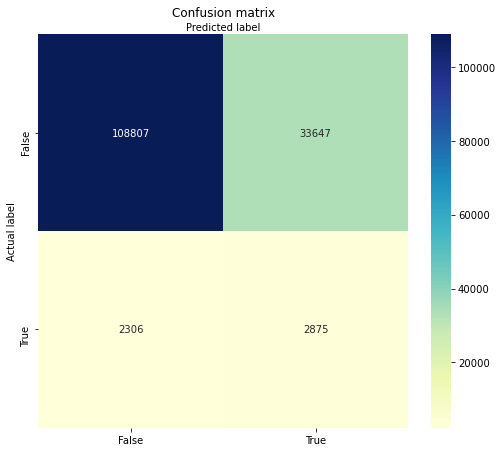

In [64]:
y_pred = nb.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
print(classification_report(y_test, y_pred))

<br>

### 2. Logistic Regression

<br>

In [59]:
lr = LogisticRegression(n_jobs = -1, class_weight = 'balanced', random_state = 3) 
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=3)

              precision    recall  f1-score   support

           0       0.98      0.80      0.88    142454
           1       0.09      0.51      0.15      5181

    accuracy                           0.79    147635
   macro avg       0.53      0.66      0.51    147635
weighted avg       0.95      0.79      0.85    147635



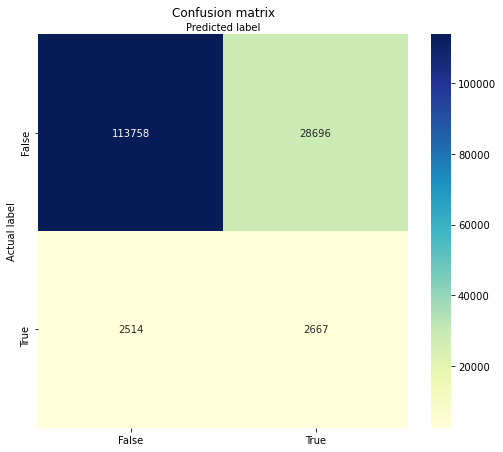

In [60]:
y_pred = lr.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
print(classification_report(y_test, y_pred))

<br>

### 3. Random Forest

<br>

In [61]:
rf =  RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=3)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142454
           1       0.93      0.35      0.51      5181

    accuracy                           0.98    147635
   macro avg       0.96      0.67      0.75    147635
weighted avg       0.98      0.98      0.97    147635



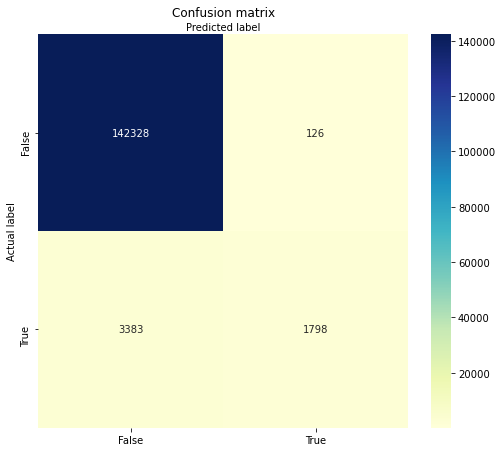

In [65]:
y_pred = rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
print(classification_report(y_test, y_pred))

<br>

### 4. Support Vector Machine

<br>

In [78]:
sv = SVC()
sv.fit(X_train, y_train)


In [ ]:
y_pred = nb.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

<br>

### 5. Gradient Boosted Decision Tree (XGBoost)

<br>

In [ ]:
param_grid = {'gamma': [0.1,0.2],
              'learning_rate': [0.01,0.02],
              'max_depth': [6,7],
              'n_estimators': [65,70],
              'reg_alpha': [0.2,0.3],
              'reg_lambda': [0.2,0.4]}
grid = GridSearchCV(XGBClassifier(), param_grid, refit = True, verbose = 3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
y_pred = nb.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

<br>

### 6. Multilayer Perceptron

<br>

Iteration 1, loss = 0.15344431
Iteration 2, loss = 0.14254796
Iteration 3, loss = 0.14139920
Iteration 4, loss = 0.14180360
Iteration 5, loss = 0.14066059
Iteration 6, loss = 0.14043479
Iteration 7, loss = 0.14062348
Iteration 8, loss = 0.14018377
Iteration 9, loss = 0.14049570
Iteration 10, loss = 0.13978757
Iteration 11, loss = 0.14061544
Iteration 12, loss = 0.14010095
Iteration 13, loss = 0.14038039
Iteration 14, loss = 0.14043060
Iteration 15, loss = 0.14072822
Iteration 16, loss = 0.14020979
Iteration 17, loss = 0.14037042
Iteration 18, loss = 0.14045644
Iteration 19, loss = 0.14041208
Iteration 20, loss = 0.14036187
Iteration 21, loss = 0.13983718
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    142454
           1       0.00      0.00      0.00      5181

    accuracy                           0.96    147635
   macro avg       0.48      

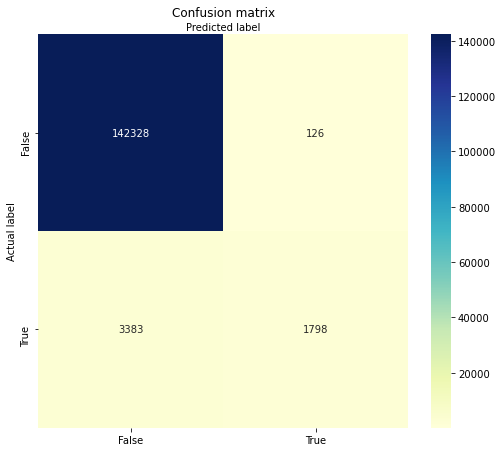

In [63]:
clf = MLPClassifier(hidden_layer_sizes=(6,5),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)
clf.fit(X_train,y_train)
ypred=clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
print(classification_report(y_test, ypred))

In [ ]:
hidden_layer_sizes=[(10,), (20,)]
activation= ['tanh', 'relu']
learning_rate_init=[0.01, 0.1, 0.001]
param_grid = dict(hidden_layer_sizes=hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate_init)

dfrst = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate_init)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)